### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import time

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model

%matplotlib inline

### Measure functions: Timing

In [2]:
def timing(function):
    def wrap(*args):
        startTime = time.time()
        ret = function(*args)
        endTime = time.time()
        print ('%s function took %0.3f ms' % (function.__name__, (endTime-startTime)*1000.0))
        return ret
    return wrap

### Machine Learning Model with Logistic Regression

In [42]:
class machineLearning:
    
    @timing
    def fit(self, df):        
        x1, y1 = correlation().calculateAxes(df)
        
        x1 = np.asarray(x1)
        x1 = x1.reshape(-1, 1)

        y1 = np.asarray(y1)
        y1 = y1.reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x1,y1, test_size=0.2, random_state=1)
        
        log = linear_model.LogisticRegression()        
        
        log.fit(x_train, y_train.ravel())
        
        y_pred = log.predict(x_test)
        
        print("Score Logistic Regression: " + str(log.score(x_test, y_test)))
        
        return log
    
    @timing
    def predict(self, df, X):        
        model = self.fit(df)
        return model.predict(X)

### Correlation

In [43]:
class correlation:
    # Calculate the axes values (x = length of word / y = count of related lemmas)
    @timing
    def calculateAxes(self, df):
        x = []
        y = []
        
        for row in df.values:
            linha = [''.join(row[:1]), [x for x in row[1:] if x is not None and x != '']]
            x.append(len(linha[0]))
            y.append(len(linha[1]))

        return x, y
    
    @timing
    def calculateCorrelation(self, df):        
        x, y = self.calculateAxes(df)

        output = pd.DataFrame()
        output['x'] = x
        output['y'] = y

        corr = output['x'].corr(output['y'])
        return corr

### API

In [44]:
class api:
    # FileName = name of input file
    # SeparatorWord = separator for word
    # SeparatorLemmas = separator for lemmas
    def __init__(self):
        self.fileName = None
        self.separatorWord = None
        self.separatorLemmas = None

    # Parse input file to Pandas DataFrame
    @timing
    def parseFile(self):
        file = pd.DataFrame(line.strip().split(self.separatorWord) for line in open(self.fileName, 'r'))
        file.columns = ['word', 'lemmas']

        parsed = pd.DataFrame(file.lemmas.str.split(self.separatorLemmas).tolist(), file['word']).add_prefix('lemma_')
        parsed.index.rename('word', inplace=True)
        parsed.reset_index(inplace=True)

        parsed['word'] = parsed['word'].str.strip()

        return parsed
    
    @timing
    def correlation(self):
        df = self.parseFile()
        return correlation().calculateCorrelation(df)
    
    @timing
    def predictMachineLearning(self, X):
        df = self.parseFile()
        predict = machineLearning().predict(df, X)
        return predict

In [60]:
test = api()

In [61]:
test.fileName = 'AntBNC_lemmas_ver_001.txt'
test.separatorWord = '->'
test.separatorLemmas = '\t'

In [62]:
result = test.correlation()
print('Correlation between the length of a word and the number of lemmas it has: ' + str(result))

parseFile function took 203.012 ms
calculateAxes function took 200.012 ms
calculateCorrelation function took 228.014 ms
correlation function took 436.025 ms
Correlation between the length of a word and the number of lemmas it has: -0.287840963695


In [48]:
print('New predict for word with lenght 6, number of lemmas is: ' + str(test.predictMachineLearning(6)))

parseFile function took 194.011 ms
calculateAxes function took 200.011 ms
Score Logistic Regression: 0.788970683198
fit function took 388.022 ms
predict function took 388.022 ms
predictMachineLearning function took 588.033 ms
New predict for word with lenght 6, number of lemmas is: [2]


### Exploratory analysis

In [55]:
df = test.parseFile()
x, y = correlation().calculateAxes(df)
del df # free memory

parseFile function took 218.012 ms
calculateAxes function took 201.011 ms


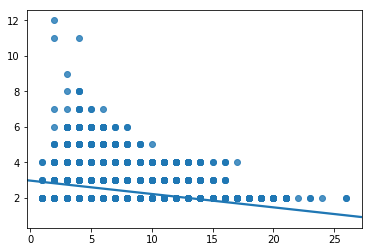

In [56]:
sb.regplot(x=np.array(x), y=np.array(y))

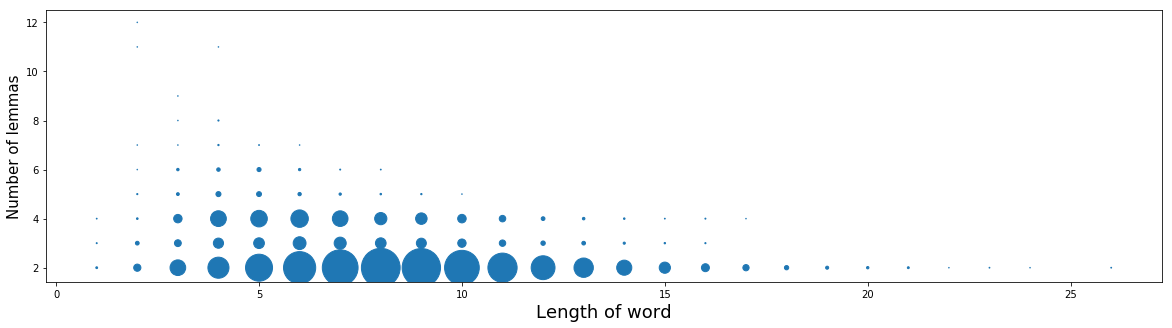

In [57]:
bubble = pd.DataFrame()
bubble['x'] = x
bubble['y'] = y
bubble['c'] = 1
bubble = bubble.groupby(['x', 'y'])['c'].sum().reset_index()

fig = plt.figure(figsize=(20,5))
plt.scatter(bubble['x'], bubble['y'], s=bubble['c']/3)
plt.xlabel("Length of word", fontsize=18)
plt.ylabel("Number of lemmas", fontsize=15)

del bubble, fig # free memory

In [58]:
del test # free memory